In [2]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from tqdm import tqdm
import glob
# direct model from google
class enhance_net_nopool(nn.Module):
    def __init__(self):
        super(enhance_net_nopool, self).__init__()
        self.relu = nn.ReLU(inplace=True)
        n = 32
        self.e_conv1 = nn.Conv2d(3, n, 3, 1, 1)
        self.e_conv2 = nn.Conv2d(n, n, 3, 1, 1)
        self.e_conv3 = nn.Conv2d(n, n, 3, 1, 1)
        self.e_conv4 = nn.Conv2d(n, n, 3, 1, 1)
        self.e_conv5 = nn.Conv2d(n * 2, n, 3, 1, 1)
        self.e_conv6 = nn.Conv2d(n * 2, n, 3, 1, 1)
        self.e_conv7 = nn.Conv2d(n * 2, 24, 3, 1, 1)

    def forward(self, x):
        x1 = self.relu(self.e_conv1(x))
        x2 = self.relu(self.e_conv2(x1))
        x3 = self.relu(self.e_conv3(x2))
        x4 = self.relu(self.e_conv4(x3))
        x5 = self.relu(self.e_conv5(torch.cat([x3, x4], 1)))
        x6 = self.relu(self.e_conv6(torch.cat([x2, x5], 1)))
        x_r = torch.tanh(self.e_conv7(torch.cat([x1, x6], 1)))
        r1, r2, r3, r4, r5, r6, r7, r8 = torch.split(x_r, 3, dim=1)
        x = x + r1 * (x ** 2 - x)
        x = x + r2 * (x ** 2 - x)
        x = x + r3 * (x ** 2 - x)
        enhance_image_1 = x + r4 * (x ** 2 - x)
        x = enhance_image_1 + r5 * (enhance_image_1 ** 2 - enhance_image_1)
        x = x + r6 * (x ** 2 - x)
        x = x + r7 * (x ** 2 - x)
        enhance_image = x + r8 * (x ** 2 - x)
        return enhance_image
class LOLDataset(Dataset):
    def __init__(self, low_dir, high_dir):
        self.low_paths = sorted(glob.glob(os.path.join(low_dir, "*.png")))
        self.high_paths = sorted(glob.glob(os.path.join(high_dir, "*.png")))
        self.transform = transforms.Compose([
            transforms.Resize((256, 256)),
            transforms.ToTensor(),
        ])

    def __len__(self):
        return len(self.low_paths)
    def __getitem__(self, idx):
        low = Image.open(self.low_paths[idx]).convert("RGB")
        high = Image.open(self.high_paths[idx]).convert("RGB")
        return self.transform(low), self.transform(high)
def train():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = enhance_net_nopool().to(device)
    criterion = nn.L1Loss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

    dataset = LOLDataset(
        low_dir=r"C:\Users\vedhr\datasets\our485\low",
        high_dir=r"C:\Users\vedhr\datasets\our485\high")
    loader = DataLoader(dataset, batch_size=4, shuffle=True)

    for epoch in range(10):
        model.train()
        epoch_loss = 0
        for low_img, high_img in tqdm(loader, desc=f"Epoch {epoch+1}"):
            low_img, high_img = low_img.to(device), high_img.to(device)
            enhanced = model(low_img)
            loss = criterion(enhanced, high_img)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        print(f"Epoch {epoch+1} Loss: {epoch_loss:.4f}")

    torch.save(model.state_dict(), "zero_dce_trained.pth")

if __name__ == "__main__":
    train()


Epoch 1: 100%|███████████████████████████████████████████████████████████████████████| 122/122 [00:32<00:00,  3.73it/s]


Epoch 1 Loss: 26.1893


Epoch 2: 100%|███████████████████████████████████████████████████████████████████████| 122/122 [00:32<00:00,  3.79it/s]


Epoch 2 Loss: 16.8091


Epoch 3: 100%|███████████████████████████████████████████████████████████████████████| 122/122 [00:32<00:00,  3.78it/s]


Epoch 3 Loss: 16.4474


Epoch 4: 100%|███████████████████████████████████████████████████████████████████████| 122/122 [00:32<00:00,  3.80it/s]


Epoch 4 Loss: 16.2921


Epoch 5: 100%|███████████████████████████████████████████████████████████████████████| 122/122 [00:31<00:00,  3.88it/s]


Epoch 5 Loss: 16.0284


Epoch 6: 100%|███████████████████████████████████████████████████████████████████████| 122/122 [00:30<00:00,  4.02it/s]


Epoch 6 Loss: 15.9700


Epoch 7: 100%|███████████████████████████████████████████████████████████████████████| 122/122 [00:31<00:00,  3.84it/s]


Epoch 7 Loss: 16.4136


Epoch 8: 100%|███████████████████████████████████████████████████████████████████████| 122/122 [00:32<00:00,  3.77it/s]


Epoch 8 Loss: 15.9439


Epoch 9: 100%|███████████████████████████████████████████████████████████████████████| 122/122 [00:32<00:00,  3.81it/s]


Epoch 9 Loss: 15.8608


Epoch 10: 100%|██████████████████████████████████████████████████████████████████████| 122/122 [00:31<00:00,  3.83it/s]

Epoch 10 Loss: 15.8992
✅ Model saved as `zero_dce_trained.pth`.


In [3]:
model = enhance_net_nopool().to(device)
model.load_state_dict(torch.load("zero_dce_trained.pth", map_location=device))
model.eval()


enhance_net_nopool(
  (relu): ReLU(inplace=True)
  (e_conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (e_conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (e_conv3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (e_conv4): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (e_conv5): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (e_conv6): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (e_conv7): Conv2d(64, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)

In [2]:
import cv2
import torch
import torchvision.transforms as transforms
from model import enhance_net_nopool  # Ensure this is in the same directory

# Initialize device and model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = enhance_net_nopool().to(device)
model.load_state_dict(torch.load("zero_dce_trained.pth", map_location=device))
model.eval()

# Define preprocessing transform
transform = transforms.Compose([
    transforms.ToTensor()
])

# Open webcam
cap = cv2.VideoCapture(0)

while True:
    ret, frame = cap.read()
    if not ret:
        break

    # Resize and normalize input frame
    input_img = cv2.resize(frame, (512, 512)) / 255.0
    input_tensor = transform(input_img.astype('float32')).unsqueeze(0).to(device)

    with torch.no_grad():
        _, enhanced_img, _ = model(input_tensor)  # Unpack all three outputs

    # Convert enhanced tensor to image
    enhanced_img = enhanced_img[0].permute(1, 2, 0).cpu().numpy()
    enhanced_img = (enhanced_img * 255).clip(0, 255).astype('uint8')

    # Display original and enhanced frames
    cv2.imshow("Original", cv2.resize(frame, (512, 512)))
    cv2.imshow("Enhanced", enhanced_img)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release resources
cap.release()
cv2.destroyAllWindows()


C:\Users\vedhr\AppData\Local\Temp\ipykernel_20752\1341385590.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("zero_dce_trained.pth", map

In [ ]:
import cv2
import torch
import torchvision.transforms as transforms
import numpy as np
from model import enhance_net_nopool
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = enhance_net_nopool().to(device)
model.load_state_dict(torch.load("zero_dce_trained.pth", map_location=device))
model.eval()
transform = transforms.Compose([
    transforms.ToTensor()
])
def contrast_stretch(image):
    in_min = np.percentile(image, 1)
    in_max = np.percentile(image, 99)
    image = (image - in_min) / (in_max - in_min)
    return np.clip(image, 0, 1)

# Sharpening Kernel
def sharpen(image):
    kernel = np.array([[0, -1, 0],
                       [-1, 5,-1],
                       [0, -1, 0]])
    return cv2.filter2D(image, -1, kernel)

# Webcam loop
cap = cv2.VideoCapture(0)

while True:
    ret, frame = cap.read()
    if not ret:
        break

    resized_frame = cv2.resize(frame, (512, 512))
    input_img = resized_frame / 255.0
    input_tensor = transform(input_img.astype('float32')).unsqueeze(0).to(device)

    with torch.no_grad():
        enhance_1, _, _ = model(input_tensor)  # First stage enhancement output

    # Convert to NumPy
    enhanced_img = enhance_1.squeeze().permute(1, 2, 0).cpu().numpy()
    enhanced_img = contrast_stretch(enhanced_img)   # Fix brightness/contrast
    enhanced_img = (enhanced_img * 255).astype('uint8')
    enhanced_img = sharpen(enhanced_img)            # Sharpen for clarity

    # Display
    cv2.imshow("Original", resized_frame)
    cv2.imshow("Enhanced", enhanced_img)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()


In [5]:
import cv2
import torch
import numpy as np
from model import enhance_net_nopool
from torchvision import transforms

# ---------------------
# Initialize Zero-DCE
# ---------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = enhance_net_nopool().to(device)
model.load_state_dict(torch.load("zero_dce_trained.pth", map_location=device))
model.eval()

# Preprocessing transform
transform = transforms.Compose([
    transforms.ToTensor()
])

# ---------------------
# Webcam Stream
# ---------------------
cap = cv2.VideoCapture(0)

while True:
    ret, frame = cap.read()
    if not ret:
        break

    # Resize to 512x512
    img_resized = cv2.resize(frame, (512, 512))

    # Normalize and convert to float32
    input_img = (img_resized / 255.0).astype(np.float32)
    input_tensor = transform(input_img).unsqueeze(0).to(device)

    # Enhance using Zero-DCE
    with torch.no_grad():
        enhanced_tensor = model(input_tensor)[0]  
    enhanced_np = enhanced_tensor.squeeze(0).permute(1, 2, 0).cpu().numpy()
    enhanced_np = (enhanced_np * 255).clip(0, 255).astype(np.uint8)
    # Sharpening( also trial and error)
    sharp_kernel = np.array([[0, -1, 0],
                             [-1, 5, -1],
                             [0, -1, 0]])
    enhanced_np = cv2.filter2D(enhanced_np, -1, sharp_kernel)
    brightness = 40   # trial and error
    contrast = 1.5    # same
    enhanced_np = cv2.convertScaleAbs(enhanced_np, alpha=contrast, beta=brightness)
    cv2.imshow("Original", cv2.resize(frame, (512, 512)))
    cv2.imshow("Enhanced", enhanced_np)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()


In [6]:
import cv2
import torch
import numpy as np
from ultralytics import YOLO
from model import enhance_net_nopool
from torchvision import transforms

# ------------------------
# Init: GPU and Models
# ------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load enhancer
enhancer = enhance_net_nopool().to(device)
enhancer.load_state_dict(torch.load("zero_dce_trained.pth", map_location=device))
enhancer.eval()

# Load YOLOv8n-face
detector = YOLO("yolov8n-face.pt")
detector.to(device)
detector.fuse()

# ------------------------
# Webcam
# ------------------------
cap = cv2.VideoCapture(0)
transform = transforms.ToTensor()

def enhance_frame(frame):
    resized = cv2.resize(frame, (512, 512))
    normalized = (resized / 255.0).astype(np.float32)
    tensor = transform(normalized).unsqueeze(0).to(device)
    with torch.no_grad():
        enhanced_tensor = enhancer(tensor)[0]
    enhanced_np = enhanced_tensor.squeeze(0).permute(1, 2, 0).cpu().numpy()
    enhanced_np = (enhanced_np * 255).clip(0, 255).astype(np.uint8)

    # Sharpen and brighten
    sharp_kernel = np.array([[0, -1, 0],
                             [-1, 5, -1],
                             [0, -1, 0]])
    enhanced_np = cv2.filter2D(enhanced_np, -1, sharp_kernel)
    enhanced_np = cv2.convertScaleAbs(enhanced_np, alpha=1.5, beta=40)
    return enhanced_np

while True:
    ret, frame = cap.read()
    if not ret:
        break

    # Enhance
    enhanced = enhance_frame(frame)

    # Detect faces on enhanced image
    results = detector(enhanced, verbose=False)
    faces = results[0].boxes
    if faces is not None and len(faces) > 0:
        # Only most confident face
        best_face = faces.conf.argmax().item()
        xyxy = faces.xyxy[best_face].int().tolist()
        cv2.rectangle(enhanced, (xyxy[0], xyxy[1]), (xyxy[2], xyxy[3]), (0, 255, 0), 2)
        cv2.putText(enhanced, "Face", (xyxy[0], xyxy[1]-10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0,255,0), 2)

    # Show both
    cv2.imshow("Original", cv2.resize(frame, (512, 512)))
    cv2.imshow("Enhanced + Detection", enhanced)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()


Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


In [1]:
import cv2
import torch
import numpy as np
import time
from ultralytics import YOLO
from model import enhance_net_nopool
from torchvision import transforms

# ------------------------
# Timer: Start
# ------------------------
startup_time = time.time()

# Init device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load enhancer
enhancer = enhance_net_nopool().to(device)
enhancer.load_state_dict(torch.load("zero_dce_trained.pth", map_location=device))
enhancer.eval()

# Load YOLOv8n-face
detector = YOLO("yolov8n-face.pt")
detector.to(device)
detector.fuse()

# Initialize webcam
cap = cv2.VideoCapture(0)
transform = transforms.ToTensor()

# Timer: End
print(f"[INFO] Startup completed in {time.time() - startup_time:.2f} seconds")

# ------------------------
# Enhance Function
# ------------------------
def enhance_frame(frame):
    resized = cv2.resize(frame, (512, 512))
    normalized = (resized / 255.0).astype(np.float32)
    tensor = transform(normalized).unsqueeze(0).to(device)
    with torch.no_grad():
        enhanced_tensor = enhancer(tensor)[0]
    enhanced_np = enhanced_tensor.squeeze(0).permute(1, 2, 0).cpu().numpy()
    enhanced_np = (enhanced_np * 255).clip(0, 255).astype(np.uint8)

    # Sharpen and brighten
    sharp_kernel = np.array([[0, -1, 0],
                             [-1, 5, -1],
                             [0, -1, 0]])
    enhanced_np = cv2.filter2D(enhanced_np, -1, sharp_kernel)
    enhanced_np = cv2.convertScaleAbs(enhanced_np, alpha=1.5, beta=40)
    return enhanced_np

# ------------------------
# Main Loop with FPS
# ------------------------
prev_time = time.time()

while True:
    ret, frame = cap.read()
    if not ret:
        break

    enhanced = enhance_frame(frame)

    # Detect face
    results = detector(enhanced, verbose=False)
    faces = results[0].boxes
    if faces is not None and len(faces) > 0:
        best_face = faces.conf.argmax().item()
        xyxy = faces.xyxy[best_face].int().tolist()
        cv2.rectangle(enhanced, (xyxy[0], xyxy[1]), (xyxy[2], xyxy[3]), (0, 255, 0), 2)
        cv2.putText(enhanced, "Face", (xyxy[0], xyxy[1] - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)

    # Calculate FPS
    curr_time = time.time()
    fps = 1.0 / (curr_time - prev_time)
    prev_time = curr_time

    # Draw FPS on enhanced frame
    cv2.putText(enhanced, f"FPS: {fps:.1f}", (10, 25), cv2.FONT_HERSHEY_SIMPLEX, 0.75, (255, 0, 0), 2)

    # Show both
    cv2.imshow("Original", cv2.resize(frame, (512, 512)))
    cv2.imshow("Enhanced + Detection", enhanced)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()


Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs
[INFO] Startup completed in 2.35 seconds


In [22]:
# required imports
import cv2
import torch
import numpy as np
import time
from ultralytics import YOLO
from model import enhance_net_nopool
from torchvision import transforms

start_time = time.time()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Zero_dce fr nigh vis
enhancer = enhance_net_nopool().to(device)
enhancer.load_state_dict(torch.load("zero_dce_trained.pth", map_location=device))
enhancer.eval()

# yolov8n used
detector = YOLO("yolov8n-face.pt").to(device)
detector.fuse()

transform = transforms.ToTensor()
cap = cv2.VideoCapture(0)
startup_delay = (time.time() - start_time) * 1000
print(f"[INFO] Startup Time: {startup_delay:.2f} ms")

prev_frame_time = time.time()

def enhance_frame(frame):
    resized = cv2.resize(frame, (512, 512))
    normalized = (resized / 255.0).astype(np.float32)
    tensor = transform(normalized).unsqueeze(0).to(device)
#enhancement part
    with torch.no_grad():
        enhanced_tensor = enhancer(tensor)[0]
    enhanced_np = enhanced_tensor.squeeze(0).permute(1, 2, 0).cpu().numpy()
    enhanced_np = (enhanced_np * 255).clip(0, 255).astype(np.uint8)
    sharp_kernel = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]])
    enhanced_np = cv2.filter2D(enhanced_np, -1, sharp_kernel)

    # scalable part
    enhanced_np = cv2.convertScaleAbs(enhanced_np, alpha=1.5, beta=40)
    return enhanced_np
while True:
    ret, frame = cap.read()
    if not ret:
        break

    frame_start = time.time()

    enhanced = enhance_frame(frame)

    # Face part
    results = detector(enhanced, verbose=False)
    faces = results[0].boxes
    if faces is not None and len(faces) > 0:
        best_face = faces.conf.argmax().item()
        xyxy = faces.xyxy[best_face].int().tolist()
        cv2.rectangle(enhanced, (xyxy[0], xyxy[1]), (xyxy[2], xyxy[3]), (0, 255, 0), 2)
        cv2.putText(enhanced, "Face", (xyxy[0], xyxy[1] - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)
    now = time.time()
    delay_ms = (now - frame_start) * 1000
    fps = 1 / (now - prev_frame_time)
    prev_frame_time = now
    cv2.putText(enhanced, f"FPS: {fps:.1f}", (10, 25),
                cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 0), 2)
    cv2.putText(enhanced, f"Delay: {delay_ms:.1f} ms", (10, 50),
                cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 255), 2)
    cv2.imshow("Original", cv2.resize(frame, (512, 512)))
    cv2.imshow("Enhanced + Detection", enhanced)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()


Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs
[INFO] Startup Time: 814.59 ms


In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import glob
import os
import cv2
import numpy as np
from tqdm.notebook import tqdm
import torch.optim as optim

In [4]:
import onnx
onnx_model = onnx.load("zero_dce.onnx")
onnx.checker.check_model(onnx_model)
print("ONNX model is valid ✅")


ONNX model is valid ✅


In [5]:
from ultralytics import YOLO

model = YOLO("yolov8n-face.pt")
model.export(format="onnx", dynamic=True)


Ultralytics 8.3.163  Python-3.10.0 torch-2.0.1+cpu CPU (13th Gen Intel Core(TM) i7-13650HX)
 ProTip: Export to OpenVINO format for best performance on Intel hardware. Learn more at https://docs.ultralytics.com/integrations/openvino/
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs

PyTorch: starting from 'yolov8n-face.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 5, 8400) (6.0 MB)
requirements: Ultralytics requirements ['onnx>=1.12.0,<1.18.0', 'onnxslim>=0.1.59'] not found, attempting AutoUpdate...
   ---------------------------------------- 14.5/14.5 MB 3.2 MB/s eta 0:00:00
  Attempting uninstall: onnx
    Found existing installation: onnx 1.18.0
    Uninstalling onnx-1.18.0:-------------- 0/2 [onnx]
      Successfully uninstalled onnx-1.18.0- 0/2 [onnx]
   ---------------------------------------- 2/2 [onnxslim]

requirements: AutoUpdate success  72.1s
WARNING requirements: Restart runtime or rerun command for updates to take effect


'yolov8n-face.onnx'

In [21]:
import cv2
import time
import numpy as np
import torch
import os
import onnxruntime as ort
from ultralytics import YOLO

# ---------------------
# Setup
# ---------------------
start_time = time.time()
device = "cuda" if torch.cuda.is_available() else "cpu"

# Load Zero-DCE ONNX
enhancer_sess = ort.InferenceSession("zero_dce2.onnx", providers=['CUDAExecutionProvider' if device == "cuda" else 'CPUExecutionProvider'])
enh_input_name = enhancer_sess.get_inputs()[0].name
enh_output_name = enhancer_sess.get_outputs()[0].name

# Export YOLOv8n-face to ONNX if not present
if not os.path.exists("yolov8n-face.onnx"):
    print("[INFO] Exporting YOLOv8n-face to ONNX...")
    YOLO("yolov8n-face.pt").export(format="onnx", dynamic=True, simplify=True)

yolo_sess = ort.InferenceSession("yolov8n-face.onnx", providers=['CUDAExecutionProvider' if device == "cuda" else 'CPUExecutionProvider'])
yolo_input_name = yolo_sess.get_inputs()[0].name

# ---------------------
# Video
# ---------------------
cap = cv2.VideoCapture(0)
startup_delay = (time.time() - start_time) * 1000
print(f"[INFO] Startup Time: {startup_delay:.2f} ms")

prev_frame_time = time.time()

def enhance_frame(frame):
    orig_h, orig_w = frame.shape[:2]

    # Resize and normalize to [0, 1]
    resized = cv2.resize(frame, (256, 256))
    input_tensor = resized.astype(np.float32) / 255.0
    input_tensor = np.transpose(input_tensor, (2, 0, 1))[None, ...]

    # Run ONNX enhancement
    output = enhancer_sess.run([enh_output_name], {enh_input_name: input_tensor})[0]

    # Convert back to image
    enhanced = np.squeeze(output)
    enhanced = np.transpose(enhanced, (1, 2, 0))

    # Only now scale to 0-255 and keep as float32 for manipulation
    enhanced = (enhanced * 255.0).clip(0, 255)

    # Apply sharpening (use float32 for better effect)
    sharp_kernel = np.array([[0, -1, 0], [-1, 9, -1], [0, -1, 0]], dtype=np.float32)
    enhanced = cv2.filter2D(enhanced, -1, sharp_kernel)

    # Apply brightness and contrast
    alpha = 1.4  # contrast
    beta = 20    # brightness
    enhanced = enhanced * alpha + beta

    # Clip again and convert to uint8
    enhanced = np.clip(enhanced, 0, 255).astype(np.uint8)

    # Resize back to original webcam resolution
    return cv2.resize(enhanced, (orig_w, orig_h))
print("Enhanced pixel stats:", enhanced.min(), enhanced.max(), enhanced.mean())


def run_yolo(image):
    h, w = image.shape[:2]
    img_resized = cv2.resize(image, (640, 640))
    img_input = img_resized.astype(np.float32) / 255.0
    img_input = np.transpose(img_input, (2, 0, 1))[None, ...]  # NCHW

    outputs = yolo_sess.run(None, {yolo_input_name: img_input})[0]

    boxes = []
    for det in outputs:
        if len(det) < 6:
            continue

        # Extract values cleanly
        x1, y1, x2, y2 = map(float, det[:4])
        conf = float(det[4])  # now guaranteed to be float

        if conf > 0.4:
            # Rescale box to original image size
            x1 = int(x1 / 640 * w)
            y1 = int(y1 / 640 * h)
            x2 = int(x2 / 640 * w)
            y2 = int(y2 / 640 * h)
            boxes.append((x1, y1, x2, y2, conf))
    return boxes





# ---------------------
# Main Loop
# ---------------------
while True:
    ret, frame = cap.read()
    if not ret:
        break

    frame_start = time.time()
    enhanced = enhance_frame(frame)
    boxes = run_yolo(enhanced)

    if boxes:
        # Pick the highest confidence
        best_box = max(boxes, key=lambda b: b[4])
        x1, y1, x2, y2, conf = best_box
        cv2.rectangle(enhanced, (x1, y1), (x2, y2), (0, 255, 0), 2)
        cv2.putText(enhanced, f"Face {conf:.2f}", (x1, y1 - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)

    # FPS + Delay
    now = time.time()
    delay_ms = (now - frame_start) * 1000
    fps = 1 / (now - prev_frame_time)
    prev_frame_time = now

    cv2.putText(enhanced, f"FPS: {fps:.1f}", (10, 25), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 0), 2)
    cv2.putText(enhanced, f"Delay: {delay_ms:.1f} ms", (10, 50), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 255), 2)

    cv2.imshow("Original", cv2.resize(frame, (512, 512)))
    cv2.imshow("Enhanced + Detection", cv2.resize(enhanced, (512, 512)))

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()


[INFO] Startup Time: 986.16 ms
Enhanced pixel stats: 0 255 254.55701497395833


In [1]:
import cv2
import time
import numpy as np
import torch
import onnxruntime as ort
from ultralytics import YOLO
from model import enhance_net_nopool
from torchvision import transforms
import matplotlib.pyplot as plt
import psutil
import GPUtil
import time
# ----------------------
# Setup
# ----------------------
start_time = time.time()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
# Load Zero-DCE from PyTorch
enhancer = enhance_net_nopool().to(device)
enhancer.load_state_dict(torch.load("zero_dce_trained.pth", map_location=device))
enhancer.eval()

start_time = time.time()
frame_count = 0
total_fps = 0
total_delay = 0
fps_list = []
delay_list = []
timestamps = []

# Load YOLOv8n-face from ONNX
if not os.path.exists("yolov8n-face.onnx"):
    print("[INFO] Exporting YOLOv8n-face to ONNX...")
    YOLO("yolov8n-face.pt").export(format="onnx", dynamic=True, simplify=True)

yolo_sess = ort.InferenceSession("yolov8n-face.onnx", providers=["CUDAExecutionProvider" if device.type == "cuda" else "CPUExecutionProvider"])
yolo_input_name = yolo_sess.get_inputs()[0].name

transform = transforms.ToTensor()
cap = cv2.VideoCapture(0)
startup_delay = (time.time() - start_time) * 1000
print(f"[INFO] Startup Time: {startup_delay:.2f} ms")

prev_frame_time = time.time()

# ----------------------
# Enhance Frame (PyTorch)
# ----------------------
def enhance_frame(frame):
    orig_h, orig_w = frame.shape[:2]
    resized = cv2.resize(frame, (256, 256))
    normalized = (resized / 255.0).astype(np.float32)
    tensor = transform(normalized).unsqueeze(0).to(device)
    with torch.no_grad():
        enhanced_tensor = enhancer(tensor)[0]
    enhanced_np = enhanced_tensor.squeeze(0).permute(1, 2, 0).cpu().numpy()
    enhanced_np = (enhanced_np * 255).clip(0, 255).astype(np.uint8)

    # Sharpen + Brighten
    sharp_kernel = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]])
    enhanced_np = cv2.filter2D(enhanced_np, -1, sharp_kernel)
    enhanced_np = cv2.convertScaleAbs(enhanced_np, alpha=1.5, beta=40)

    return cv2.resize(enhanced_np, (orig_w, orig_h))

# ----------------------
# Run YOLO ONNX
# ----------------------
# ----------------------
# Run YOLO ONNX (Corrected)
# ----------------------
def run_yolo(image):
    h, w = image.shape[:2]
    conf_threshold = 0.45  # Confidence threshold
    nms_threshold = 0.5   # NMS threshold

    # Preprocess the image for YOLO
    img_resized = cv2.resize(image, (640, 640))
    img_input = img_resized.astype(np.float32) / 255.0
    img_input = np.transpose(img_input, (2, 0, 1))[None, ...]  # HWC to NCHW

    # Run inference
    outputs = yolo_sess.run(None, {yolo_input_name: img_input})[0]

    # Post-process the output
    # Transpose and squeeze the output from (1, 5, 8400) to (8400, 5)
    predictions = np.squeeze(outputs).T

    # Filter out detections with low confidence
    scores = predictions[:, 4]
    high_conf_indices = scores > conf_threshold
    predictions = predictions[high_conf_indices]
    scores = scores[high_conf_indices]

    # The model outputs center_x, center_y, width, height in 640x640 scale.
    # Convert them to x1, y1 (top-left) and box width, height.
    cx, cy, box_w, box_h = predictions[:, 0], predictions[:, 1], predictions[:, 2], predictions[:, 3]
    x1 = cx - box_w / 2
    y1 = cy - box_h / 2

    # Scale boxes back to the original image dimensions
    scale_x = w / 640.0
    scale_y = h / 640.0
    
    # Create lists for NMS
    # cv2.dnn.NMSBoxes expects boxes as a list of [x, y, w, h]
    nms_boxes = [[int(x * scale_x), int(y * scale_y), int(bw * scale_x), int(bh * scale_y)] for x, y, bw, bh in zip(x1, y1, box_w, box_h)]
    
    final_boxes = []
    if len(nms_boxes) > 0:
        # Apply Non-Maximum Suppression
        indices = cv2.dnn.NMSBoxes(nms_boxes, scores.tolist(), conf_threshold, nms_threshold)
        
        # Process the remaining boxes
        for i in indices:
            box = nms_boxes[i]
            score = scores[i]
            x, y, bw, bh = box[0], box[1], box[2], box[3]
            
            # Append as (x1, y1, x2, y2, confidence)
            final_boxes.append((x, y, x + bw, y + bh, float(score)))
            
    return final_boxes


# ----------------------
# Main Loop
# ----------------------
while True:
    ret, frame = cap.read()
    if not ret:
        break

    frame_start = time.time()
    enhanced = enhance_frame(frame)
    boxes = run_yolo(enhanced)

    if boxes:
        best_box = max(boxes, key=lambda b: b[4])
        x1, y1, x2, y2, conf = best_box
        cv2.rectangle(enhanced, (x1, y1), (x2, y2), (0, 255, 0), 2)
        cv2.putText(enhanced, f"Face {conf:.2f}", (x1, y1 - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)

    now = time.time()
    delay_ms = (now - frame_start) * 1000
    fps = 1 / (now - prev_frame_time)
    prev_frame_time = now

    frame_count += 1
    total_fps += fps
    total_delay += delay_ms

    cv2.putText(enhanced, f"FPS: {fps:.1f}", (10, 25), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 0), 2)
    cv2.putText(enhanced, f"Delay: {delay_ms:.1f} ms", (10, 50), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 0), 2)

    cv2.imshow("Original", cv2.resize(frame, (512, 512)))
    cv2.imshow("Enhanced + Detection", cv2.resize(enhanced, (512, 512)))
    fps_list.append(fps)
    delay_list.append(delay_ms)
    timestamps.append(now - start_time)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()


# Final performance summary
end_time = time.time()
total_runtime = end_time - start_time

# CPU Memory usage
mem = psutil.virtual_memory()

# GPU Usage
gpu_stats = GPUtil.getGPUs()
if gpu_stats:
    gpu = gpu_stats[0]
    gpu_load = f"{gpu.load * 100:.1f}%"
    gpu_mem_used = f"{gpu.memoryUsed} MB / {gpu.memoryTotal} MB"
else:
    gpu_load = "N/A"
    gpu_mem_used = "N/A"

# Print performance summary
print("\n--- Performance Summary ---")
print(f"Total Runtime       : {total_runtime:.2f} seconds")
print(f"Total Frames        : {frame_count}")
print(f"Average FPS         : {total_fps / frame_count:.2f}")
print(f"Average Delay       : {total_delay / frame_count:.2f} ms")
print(f"CPU Memory Usage    : {mem.percent:.2f}%")
print(f"GPU Load            : {gpu_load}")
print(f"GPU Memory Usage    : {gpu_mem_used}")

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(timestamps, fps_list, label="FPS", color="blue")
plt.xlabel("Time (s)")
plt.ylabel("Frames Per Second")
plt.title("FPS vs Time")
plt.grid(True)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(timestamps, delay_list, label="Delay (ms)", color="green")
plt.xlabel("Time (s)")
plt.ylabel("Delay per Frame (ms)")
plt.title("Delay vs Time")
plt.grid(True)
plt.legend()
plt.ylim(0, 30) 
plt.yticks(np.arange(0, 31, 5))  


plt.tight_layout()
plt.show()


cuda


C:\Users\vedhr\AppData\Local\Temp\ipykernel_10324\1370152034.py:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  enhancer.load_state_dict(torch.load("zero_dce_trained.pth",

NameError: name 'os' is not defined

Running on: cuda


C:\Users\vedhr\AppData\Local\Temp\ipykernel_28920\3624809182.py:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  enhancer.load_state_dict(torch.load("zero_dce_trained.pth",

Startup time: 1638.41 ms

- Performance Summary -
Total time: 7.99 sec
Frames: 76
Avg FPS: 24.91
Avg Delay: 53.56 ms
Script RAM Usage: 1288.71 MB
GPU Load: 0.0%
GPU Mem: 578.0MB / 8188.0MB


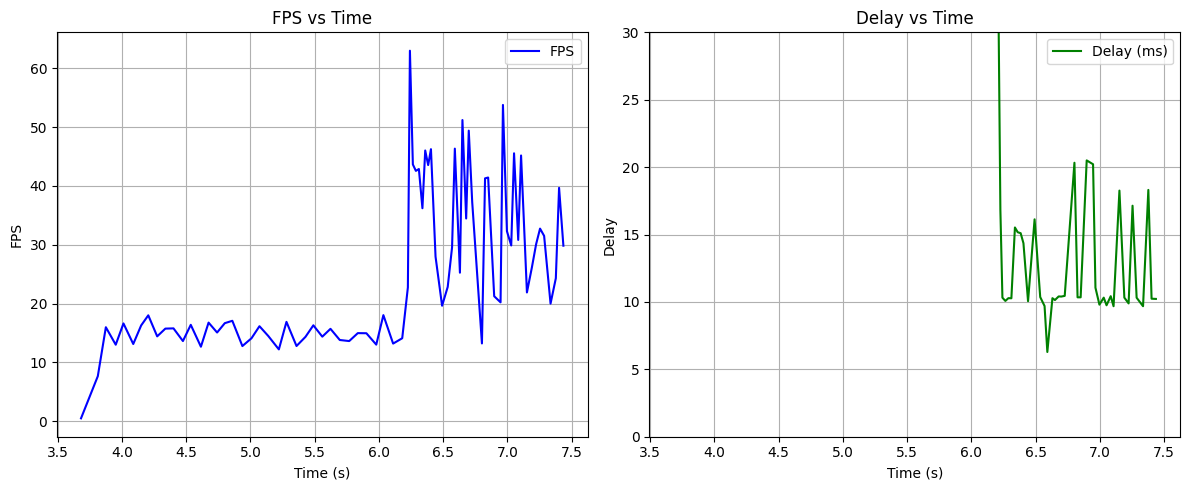

In [1]:
import os
import cv2
import time
import numpy as np
import torch
import onnxruntime as ort
from torchvision import transforms
from model import enhance_net_nopool
import matplotlib.pyplot as plt
import psutil
import GPUtil

# basic setup
start_time = time.time()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Running on:", device)

# load zero-dce model
enhancer = enhance_net_nopool().to(device)
enhancer.load_state_dict(torch.load("zero_dce_trained.pth", map_location=device))
enhancer.eval()

if not os.path.exists("yolov8n-face.onnx"):
    from ultralytics import YOLO
    YOLO("yolov8n-face.pt").export(format="onnx", dynamic=True, simplify=True)

# yolo onnx
providers = ["CUDAExecutionProvider"] if device.type == "cuda" else ["CPUExecutionProvider"]
yolo_sess = ort.InferenceSession("yolov8n-face.onnx", providers=providers)
yolo_input_name = yolo_sess.get_inputs()[0].name

# webcam
cap = cv2.VideoCapture(0)
print(f"Startup time: {(time.time() - start_time) * 1000:.2f} ms")

# tracking vars
transform = transforms.ToTensor()
prev_frame_time = time.time()
frame_count = 0
total_fps = 0
total_delay = 0
timestamps = []
fps_list = []
delay_list = []

def enhance_frame(frame):
    h, w = frame.shape[:2]
    frame_resized = cv2.resize(frame, (256, 256))
    norm = (frame_resized / 255.0).astype(np.float32)
    tensor = transform(norm).unsqueeze(0).to(device)

    with torch.no_grad():
        output = enhancer(tensor)[0]
    enhanced = output.squeeze(0).permute(1, 2, 0).cpu().numpy()
    enhanced = (enhanced * 255).clip(0, 255).astype(np.uint8)

    # quick sharpen + brightness
    sharpen = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]])
    enhanced = cv2.filter2D(enhanced, -1, sharpen)
    enhanced = cv2.convertScaleAbs(enhanced, alpha=1.5, beta=40)

    return cv2.resize(enhanced, (w, h))

def run_yolo(img):
    h, w = img.shape[:2]
    img_resized = cv2.resize(img, (640, 640)).astype(np.float32) / 255.0
    input_blob = np.transpose(img_resized, (2, 0, 1))[None, ...]

    out = yolo_sess.run(None, {yolo_input_name: input_blob})[0]
    preds = np.squeeze(out).T

    confs = preds[:, 4]
    keep = confs > 0.45
    preds, confs = preds[keep], confs[keep]

    cx, cy, bw, bh = preds[:, 0], preds[:, 1], preds[:, 2], preds[:, 3]
    x1 = cx - bw / 2
    y1 = cy - bh / 2

    scale_x, scale_y = w / 640.0, h / 640.0
    boxes = [[int(x * scale_x), int(y * scale_y), int(bw_ * scale_x), int(bh_ * scale_y)]
             for x, y, bw_, bh_ in zip(x1, y1, bw, bh)]

    final = []
    if boxes:
        idxs = cv2.dnn.NMSBoxes(boxes, confs.tolist(), 0.45, 0.5)
        for i in idxs:
            x, y, bw_, bh_ = boxes[i]
            final.append((x, y, x + bw_, y + bh_, float(confs[i])))

    return final

# main loop
while True:
    ret, frame = cap.read()
    if not ret:
        break

    t0 = time.time()
    enhanced = enhance_frame(frame)
    boxes = run_yolo(enhanced)

    if boxes:
        x1, y1, x2, y2, conf = max(boxes, key=lambda b: b[4])
        cv2.rectangle(enhanced, (x1, y1), (x2, y2), (0, 255, 0), 2)
        cv2.putText(enhanced, f"Face {conf:.2f}", (x1, y1 - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)

    t1 = time.time()
    delay = (t1 - t0) * 1000
    fps = 1 / (t1 - prev_frame_time)
    prev_frame_time = t1

    frame_count += 1
    total_fps += fps
    total_delay += delay
    fps_list.append(fps)
    delay_list.append(delay)
    timestamps.append(t1 - start_time)

    cv2.putText(enhanced, f"FPS: {fps:.1f}", (10, 25), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 0), 2)
    cv2.putText(enhanced, f"Delay: {delay:.1f} ms", (10, 50), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 0), 2)

    cv2.imshow("Original", cv2.resize(frame, (512, 512)))
    cv2.imshow("Enhanced + Detection", cv2.resize(enhanced, (512, 512)))

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

# memory and GPU usage
mem = psutil.virtual_memory()
gpu = GPUtil.getGPUs()[0] if GPUtil.getGPUs() else None

# summary
print("\n- Performance Summary -")
import os, psutil


print(f"Total time: {time.time() - start_time:.2f} sec")
print(f"Frames: {frame_count}")
print(f"Avg FPS: {total_fps / frame_count:.2f}")
print(f"Avg Delay: {total_delay / frame_count:.2f} ms")
process = psutil.Process(os.getpid())
print(f"Script RAM Usage: {process.memory_info().rss / (1024 ** 2):.2f} MB")
print(f"GPU Load: {f'{gpu.load*100:.1f}%' if gpu else 'N/A'}")
print(f"GPU Mem: {f'{gpu.memoryUsed}MB / {gpu.memoryTotal}MB' if gpu else 'N/A'}")

# plotting
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(timestamps, fps_list, color='blue', label='FPS')
plt.xlabel("Time (s)")
plt.ylabel("FPS")
plt.title("FPS vs Time")
plt.grid(True)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(timestamps, delay_list, color='green', label='Delay (ms)')
plt.xlabel("Time (s)")
plt.ylabel("Delay")
plt.title("Delay vs Time")
plt.grid(True)
plt.legend()
plt.ylim(0, 30)
plt.yticks(np.arange(0, 31, 5))

plt.tight_layout()
plt.show()
